In [1]:
import pathlib
import sys

sys.path.append("../")
sys.path.append("../utils/")

local_path = pathlib.Path().resolve()
local_path

PosixPath('/Users/nielsota/Downloads/Niels/Code/StateSpacing/nbs')

In [2]:
from typing import List, Optional, Dict, Tuple
from scipy.optimize import minimize
from collections import deque
from matplotlib import animation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import custom functions

In [4]:
from statespace.utils import _initiate_variables, _map_vector_to_matrices, _get_nan_positions, _remove_nan_tensor, _remove_inf_tensor, _get_bounds, read_target_from_path
from statespace.StateSpacingKalman import KalmanV1
from statespace.StateSpacingProtocols import KalmanProtocol, MathProtocol
from statespace.StateSpacingClasses import LinearGaussianModel_v2_numpy as LGM
from statespace.StateSpacingClasses import LLM_v1_numpy as LLM

# Local Level Using General Formulation

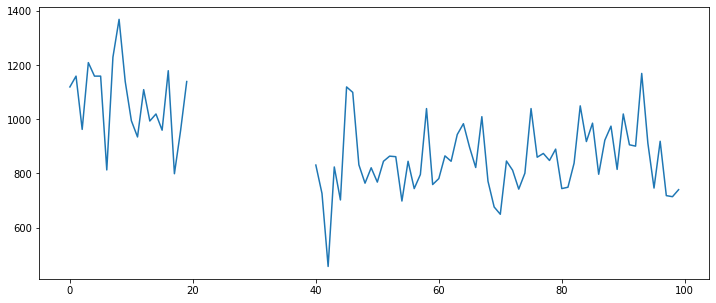

In [5]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(nile_path, dtype, header='infer')
y[:, :, 20:40] = np.nan

plt.figure(figsize=(12, 5))
plt.plot(np.squeeze(y))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36403D+05    |proj g|=  2.16156D+05

At iterate    1    f=  1.94231D+05    |proj g|=  7.04501D+04

At iterate    2    f=  1.60680D+05    |proj g|=  4.80007D+04

At iterate    3    f=  1.17032D+05    |proj g|=  2.53298D+04

At iterate    4    f=  8.96333D+04    |proj g|=  1.48091D+04

At iterate    5    f=  6.73589D+04    |proj g|=  8.33770D+03

At iterate    6    f=  5.10097D+04    |proj g|=  4.76680D+03

At iterate    7    f=  3.85357D+04    |proj g|=  2.71058D+03

At iterate    8    f=  2.91610D+04    |proj g|=  1.54498D+03

At iterate    9    f=  2.20756D+04    |proj g|=  8.79951D+02

At iterate   10    f=  1.67330D+04    |proj g|=  5.01357D+02

At iterate   11    f=  1.27017D+04    |proj g|=  2.85616D+02

At iterate   12    f=  9.66161D+03    |proj g|=  1.62711D+02

At iterate   13    f=  7.3

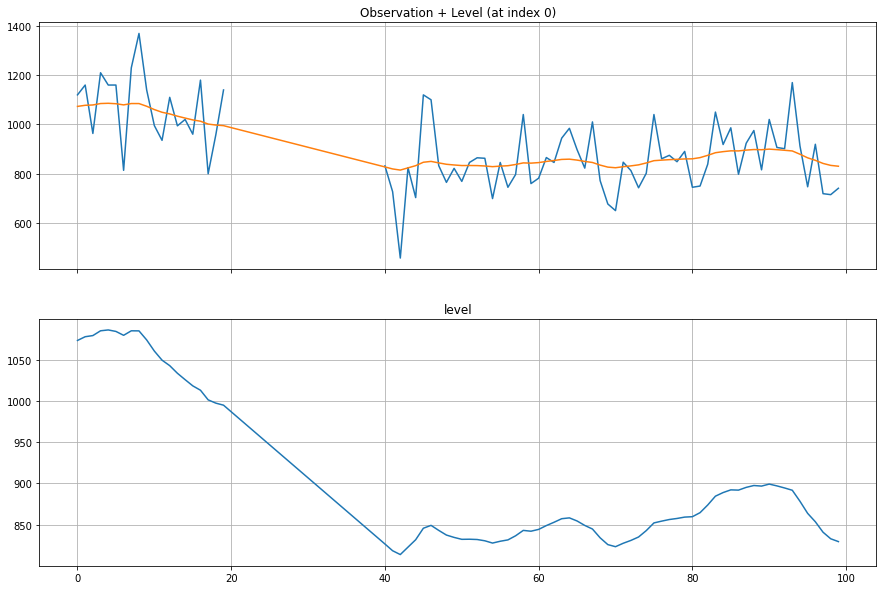

In [6]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
R = np.array([[1]]).astype(dtype)
Q = np.array([[1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llm = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1:  {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level"}

llm = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llm, filter_map)
llm.fit()
llm.plot_states()

# Local Linear Trend Using General Formulation

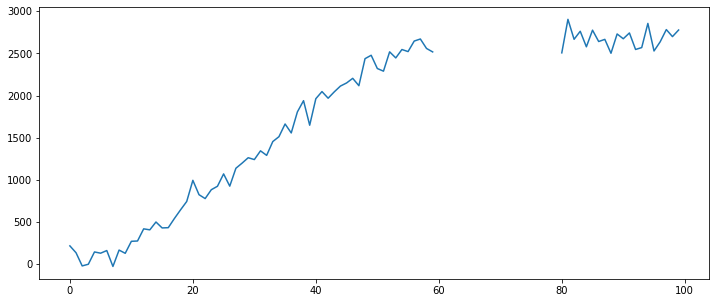

In [7]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llt.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
y[:, :, 60:80] = np.nan

#key point: clear trend, but trend changing
plt.figure(figsize=(12, 5))
plt.plot(np.squeeze(y))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80431D+05    |proj g|=  1.14407D+05

At iterate    1    f=  1.07373D+05    |proj g|=  3.91339D+04

At iterate    2    f=  8.85006D+04    |proj g|=  2.63531D+04

At iterate    3    f=  6.47658D+04    |proj g|=  1.39611D+04

At iterate    4    f=  4.96165D+04    |proj g|=  8.13162D+03

At iterate    5    f=  3.73509D+04    |proj g|=  4.58155D+03

At iterate    6    f=  2.83045D+04    |proj g|=  2.61461D+03

At iterate    7    f=  2.14172D+04    |proj g|=  1.48621D+03

At iterate    8    f=  1.62439D+04    |proj g|=  8.47153D+02

At iterate    9    f=  1.23279D+04    |proj g|=  4.82423D+02

At iterate   10    f=  9.37961D+03    |proj g|=  2.74800D+02

At iterate   11    f=  7.15659D+03    |proj g|=  1.56632D+02

At iterate   12    f=  5.47904D+03    |proj g|=  8.89814D+01

At iterate   13    f=  4.2

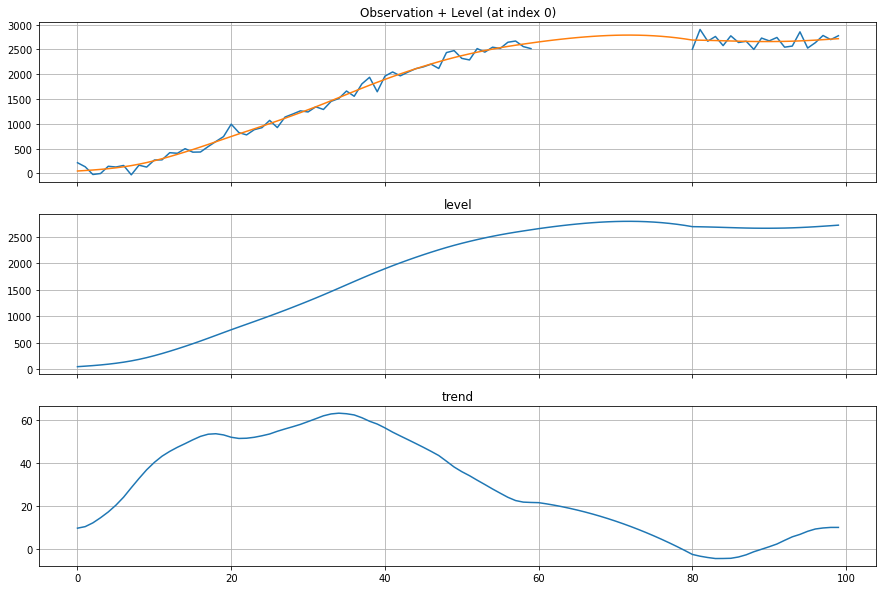

In [8]:
# Declare State Matrices Local linear Trend Model -> use [[]] for extra dimension
T = np.array([[1, 1], [0, 1]]).astype(dtype)
Z = np.array([[1, 0]]).astype(dtype)
R = np.array([[1, 0], [0, 1]]).astype(dtype)
Q = np.array([[1, 0], [0, 1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llt = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend"}

llt = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llt, filter_map)
llt.fit()
llt.plot_states()

# Local Linear Trend w/ Seasonal Component

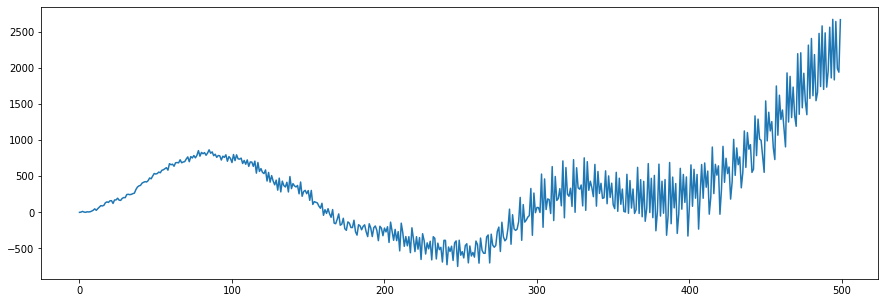

In [9]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llts.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
#y[:, :, 400:500] = np.nan

plt.figure(figsize=(15, 5))
plt.plot(np.squeeze(y))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04307D+05    |proj g|=  6.57003D+04

At iterate    1    f=  6.37932D+04    |proj g|=  2.15262D+04

At iterate    2    f=  5.32886D+04    |proj g|=  1.45209D+04

At iterate    3    f=  3.93826D+04    |proj g|=  7.51863D+03

At iterate    4    f=  3.07832D+04    |proj g|=  4.48331D+03

At iterate    5    f=  2.32881D+04    |proj g|=  2.46779D+03

At iterate    6    f=  1.80745D+04    |proj g|=  1.41800D+03

At iterate    7    f=  1.40685D+04    |proj g|=  7.97475D+02

At iterate    8    f=  1.11651D+04    |proj g|=  4.59960D+02

At iterate    9    f=  8.86753D+03    |proj g|=  2.58580D+02

At iterate   10    f=  7.22102D+03    |proj g|=  1.48406D+02

At iterate   11    f=  5.96010D+03    |proj g|=  8.46172D+01

At iterate   12    f=  5.02717D+03    |proj g|=  4.76325D+01

At iterate   13    f=  4.3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


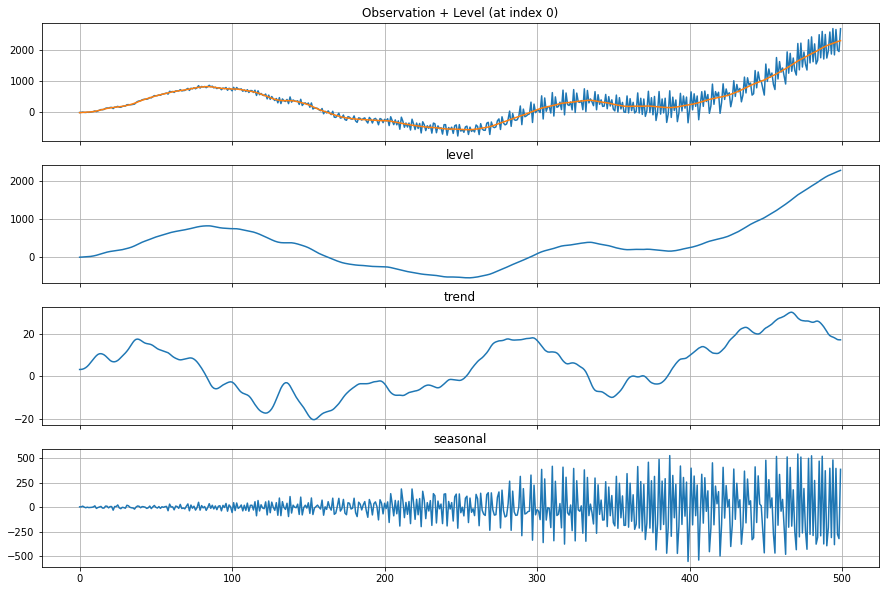

In [10]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1], 
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0]]).astype(dtype)

R = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0]]).astype(dtype)

Q = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llts = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal"}

llts = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
llts.fit()
llts.plot_states(signal_components=['level'])

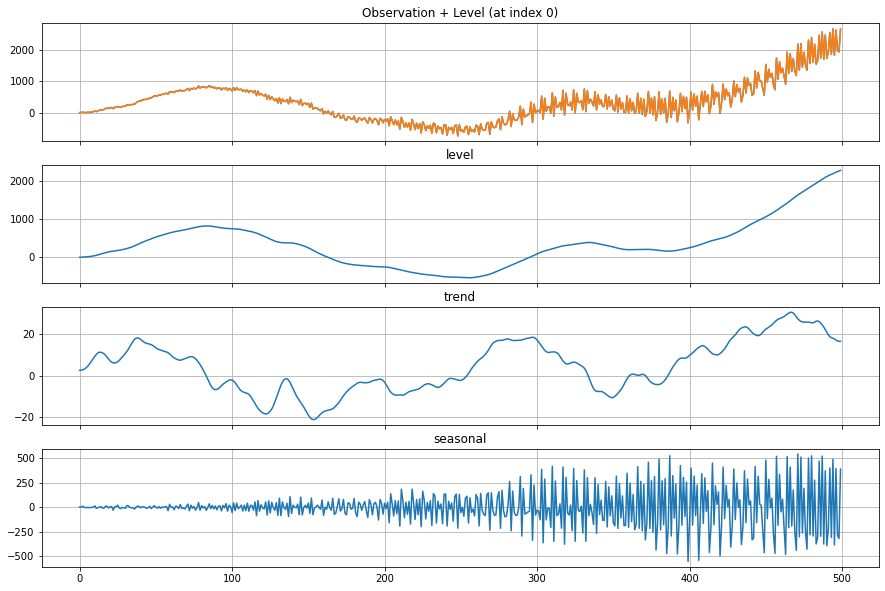

In [8]:
llts.plot_states(signal_components=['level', 'seasonal'])

# Local Linear Trend w/ Seasonal Component and Exogenous Regressor

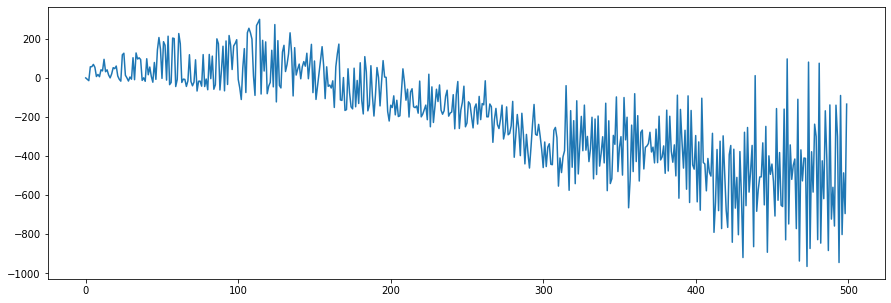

In [9]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
lltsx_path = data_dir / 'lltsX.txt'
regressor_path = data_dir / 'regressor.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(lltsx_path, dtype)
X = read_target_from_path(regressor_path, dtype)
# y[:, :, 400:500] = np.nan

plt.figure(figsize=(15, 5))
plt.plot(np.squeeze(y))

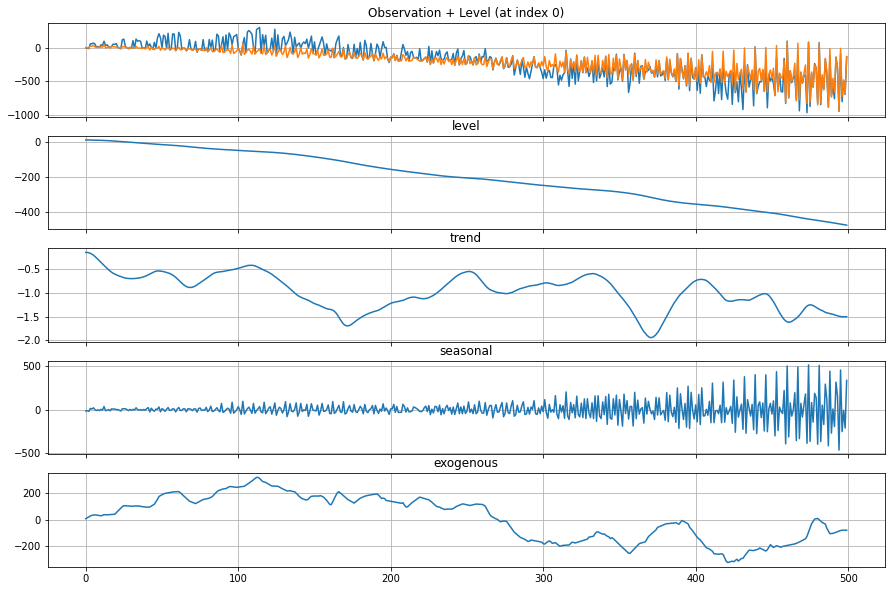

In [10]:
# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1, 0], 
              [0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 8, :] = X 

R = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0],
              [0, 0, 0, 1]]).astype(dtype)

Q = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_lltsX = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "Q", "index": (3, 3, 0), "constant": True, "bounds": (0.1, None)},
    4: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal", 8: "exogenous"}

lltsX = LGM(y, T, Z, R, Q, H, diffuse, dict_param_lltsX, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=['level', 'seasonal'])

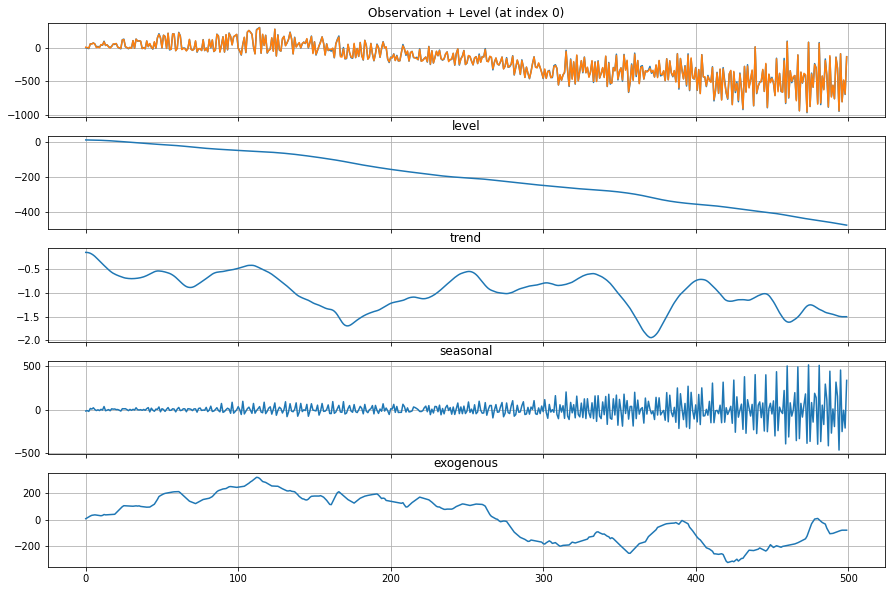

In [11]:
lltsX.plot_states(signal_components=['level', 'seasonal', 'exogenous'])

# Regression (with missing observations)

Slope set to 100 during data generating process

How to make slope parameter time varying? Interpretable as changing effect of exogenous variable. 

In [ ]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
y_path = data_dir / 'standard_regressionY.txt'
x_path = data_dir / 'standard_regressionX.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(y_path, dtype)
X = read_target_from_path(x_path, dtype)
# y[:, :, 400:500] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 0, :] = X 

R = np.array([[1]]).astype(dtype)
Q = np.array([[0]]).astype(dtype)
H = np.array([[1]]).astype(dtype)

diffuse = True

dict_param_llts = {
    0: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
}

filter_map = {0: "exogenous"}

lltsX = LGM(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=["exogenous"])